In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import pad_sequences, set_random_seed
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional, Dropout

# Встановлюємо гіперпараметри

In [2]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

# Завантаження даних:

In [3]:
from keras.datasets import imdb

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# Завантаження тренувальних та тестових даних зі вказанням обмеження на кількість слів

# Опис датасету IMDB

Датасет IMDB являє собою набір відгуків про фільми з сайту Internet Movie Database (IMDB). 

1. Дані (`input`): Це послідовності індексів слів, що представляють тексти відгуків про фільми. Кожен елемент у датасеті являє собою один відгук. Наприклад, `train_data[0]` містить послідовність індексів для першого відгуку.
2. Мітки (`y`): Це бінарні значення (`0` або `1`), що представляють собою негативний або позитивний відгук. Наприклад, `train_labels[0]` містить мітку (`0` або `1`) для першого відгуку, вказуючи на те, негативний це відгук чи позитивний.

Приклади:

`train_data[0]`: `[1, 14, 22, 16, 43, ...]` (послідовність індексів слів першого відгуку)
train_labels[0]: 1 (мітка, що вказує на позитивний відгук)

Для декодування цих індексів назад у слова, можна використати словник `imdb.get_word_index()`, що надається `Keras`. 



## Розміри датасета


### Тренувальний датасет:
Розмір тренувальних даних: `(25000,)`
Розмір міток тренувальних даних: `(25000,)`

### Тестовий датасет:
Розмір тестових даних: `(25000,)`
Розмір міток тестових даних: `(25000,)`



In [5]:
# Декодуємо відгук


def decode_review(numberlist: list):
    word_to_id = imdb.get_word_index()
    word_to_id = {k: (v + 3) for k, v in word_to_id.items()}
    # word_to_id["<PAD>"] = 0
    # word_to_id["<START>"] = 1
    # word_to_id["<UNK>"] = 2
    # word_to_id["<UNUSED>"] = 3
    word_to_id = {v: k for k, v in word_to_id.items()}
    id_to_word = [
        word_to_id.get(word) for word in numberlist if word not in range(0, 3)
    ]
    return " ".join(id_to_word)

In [6]:
index = 1
print(f"Відгук: {input_train[index]}")
print(f"Декодований: {decode_review(input_train[index])}")
print(f"Мітка: {y_train[index]}")

Відгук: [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
Декодований: big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've s

# Передпроцесинг послідовних даних:

In [7]:
x_train = pad_sequences(input_train, maxlen=maxlen)
x_test = pad_sequences(input_test, maxlen=maxlen)
# Застосування заздалегідь обраної максимальної довжини до послідовних даних тренувального та тестового наборів

# Побудова моделей

1. [SimpleRNN layer](https://keras.io/api/layers/recurrent_layers/simple_rnn/)
2. [LSTM layer](https://keras.io/api/layers/recurrent_layers/lstm/)

Для порівняння моделі створимо з однаковим числом шарів, та з однаковими параметрами

In [8]:
class BaseModel:
    def __init__(self, name, max_features, layer):
        self.name = name
        self.max_features = max_features
        self.build = self.build_model(layer)

    def build_model(self, layers: list):
        model = Sequential()
        model.add(Embedding(self.max_features, 64))
        for layer in layers:
            model.add(layer)
        model.add(Dropout(0.4))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
        return model


class SimpleRNNModel(BaseModel):
    def __init__(self, name="SRNN", max_features=max_features):
        super().__init__(name, max_features, [SimpleRNN(units=64)])


class LSTMModel(BaseModel):
    def __init__(self, name="LSTM", max_features=max_features):
        super().__init__(name, max_features, [LSTM(units=64)])


class BidirectionalRNNModel(BaseModel):
    def __init__(self, name="Bidirectional_SRNN", max_features=max_features):
        super().__init__(name, max_features, [Bidirectional(SimpleRNN(units=64))])


class BidirectionalLSTMModel(BaseModel):
    def __init__(self, name="Bidirectional_LSTM", max_features=max_features):
        super().__init__(
            name,
            max_features,
            [
                Bidirectional(LSTM(units=64)),
            ],
        )

# Створення моделей

In [10]:
models = []

for model_class in [
    SimpleRNNModel,
    BidirectionalRNNModel,
    LSTMModel,
    BidirectionalLSTMModel,
]:
    model_instance = model_class()
    models.append(model_instance)

# Навчання моделей

In [11]:
epochs = 5
batch_size = 2**6

In [12]:
models_info = {}
set_random_seed(42)

for model in models:
    print(f"\nStart learning model: {model.name}\n")
    model.build.summary()

    start_time = time.time()
    history = model.build.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.3,
        verbose=1,
    )
    end_time = time.time()

    # Додаємо історію, та час навчання до словника
    models_info.setdefault(model.name, {})["history"] = history
    models_info[model.name]["edu_time"] = round(end_time - start_time, 2)

    start_time = time.time()
    test_loss, test_acc = model.build.evaluate(x_test, y_test)
    end_time = time.time()

    # Визначаємо функцію втрат та точність на тестових даних
    print(f"Test Loss: {test_loss:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")
    models_info[model.name]["test_loss"] = round(test_loss, 2)
    models_info[model.name]["test_acc"] = round(test_acc, 2)
    models_info[model.name]["eval_time"] = round(end_time - start_time, 2)


Start learning model: SRNN

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          640000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 648321 (2.47 MB)
Trainable params: 648321 (2.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5


274/274 [==============================] - 23s 77ms/step - loss: 0.6597 - acc: 0.5885 - val_loss: 0.7334 - va

# Підсумки


Візуалізація кривих навчання

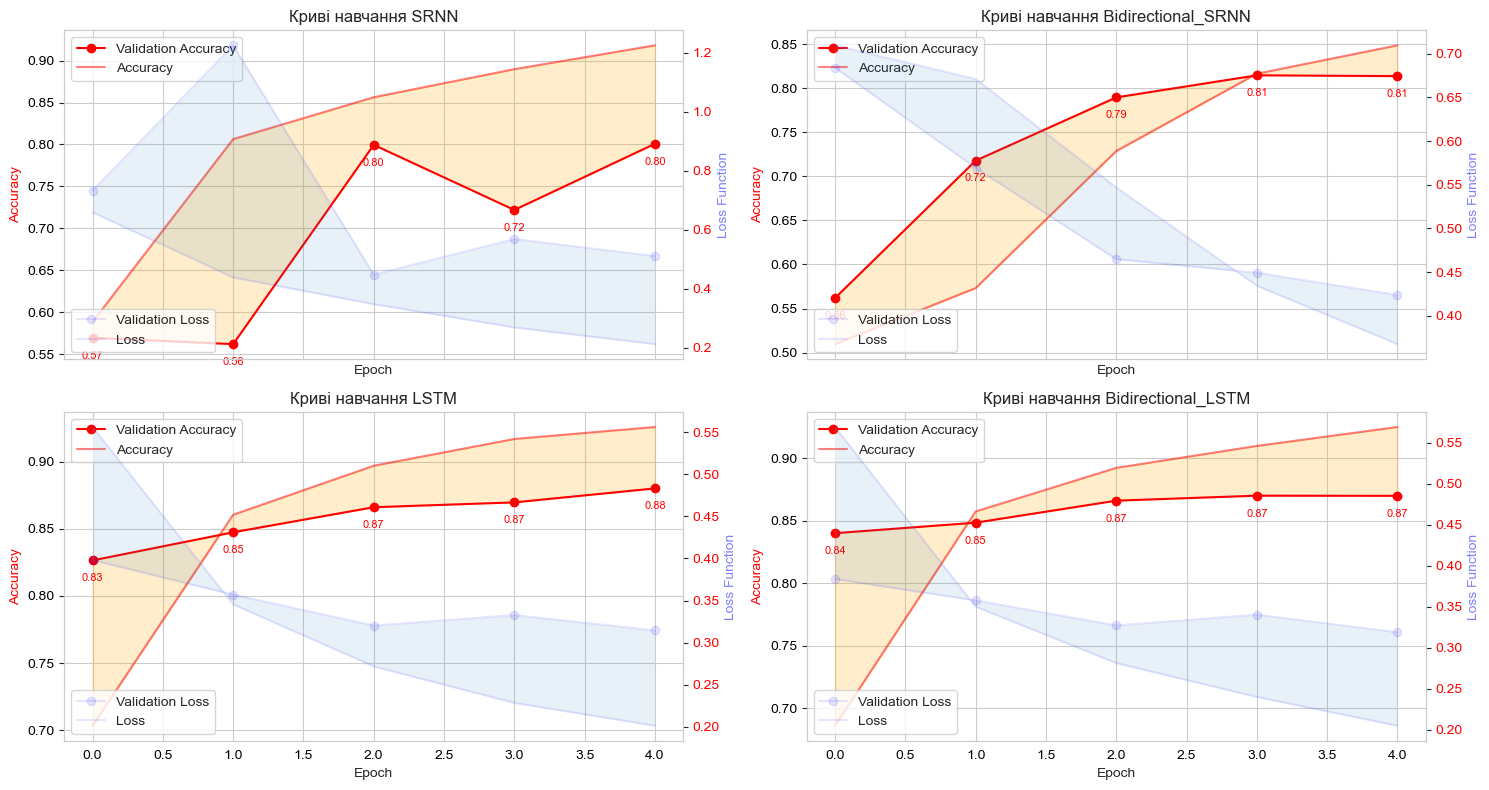

In [15]:
fig, axs = plt.subplots(
    len(models_info) // 2, 2, figsize=(15, 4 * (len(models_info) // 2)), sharex=True
)

for i, (model_name, model_info) in enumerate(models_info.items()):
    history = model_info["history"]

    row = i // 2
    col = i % 2

    ax1 = axs[row, col]

    val_loss = history.history["val_loss"]
    loss = history.history["loss"]
    val_accuracy = history.history["val_acc"]
    accuracy = history.history["acc"]

    ax1.plot(val_accuracy, label="Validation Accuracy", marker="o", color="r")
    ax1.plot(accuracy, label="Accuracy", color="r", alpha=0.5)
    ax1.fill_between(
        range(len(accuracy)), accuracy, val_accuracy, color="orange", alpha=0.2
    )
    ax1.tick_params(labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy", color="r")

    for j, acc in enumerate(val_accuracy):
        ax1.annotate(
            f"{acc:.2f}",
            (j, acc),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
            c="r",
            fontsize=8,
        )

    ax2 = ax1.twinx()

    ax2.plot(val_loss, label="Validation Loss", marker="o", color="b", alpha=0.1)
    ax2.plot(loss, label="Loss", color="b", alpha=0.1)
    ax2.set_ylabel("Loss Function", color="b", alpha=0.5)
    ax2.fill_between(range(len(loss)), loss, val_loss, alpha=0.1)

    ax2.tick_params(axis="y", labelcolor="r")
    ax2.grid(True, linestyle="--")

    ax2.legend(loc="lower left")

    plt.grid()
    plt.title(f"Криві навчання {model_name}")

plt.tight_layout()
plt.savefig(f"training_curves_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

Наведемо підсумкові дані до таблиці

In [16]:
import pandas as pd

df = pd.DataFrame(models_info)

# Deleting the column 'history'
df = df.drop(
    "history",
    axis=0,
).transpose()

df

,edu_time,test_loss,test_acc,eval_time
SRNN,103.42,0.52,0.8,11.45
Bidirectional_SRNN,151.49,0.41,0.82,13.97
LSTM,271.72,0.34,0.87,31.12
Bidirectional_LSTM,476.97,0.33,0.86,42.54


In [ ]:
df.to_csv(f"data_epochs_{epochs}_batch_{batch_size}.csv", index=True, sep=" ")

Візуалізуємо ці результати

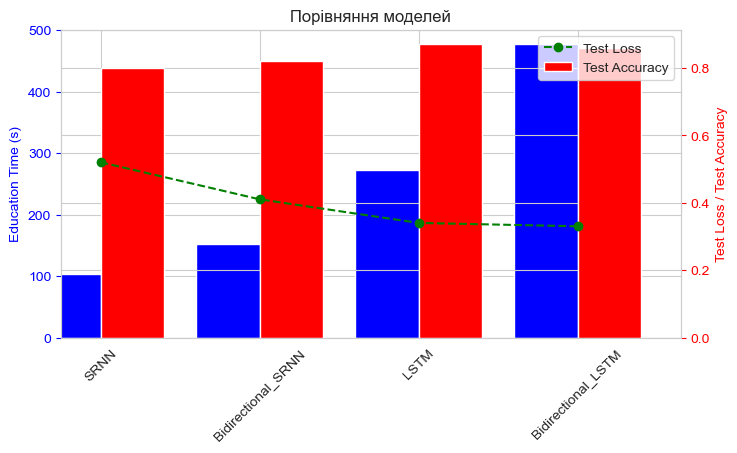

In [17]:
fig, ax1 = plt.subplots(figsize=(8, 4))

df["edu_time"].plot(kind="bar", ax=ax1, position=1, color="b", width=0.4)
ax1.set_ylabel("Education Time (s)", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
df["test_acc"].plot(kind="bar", ax=ax2, position=0, color="r", width=0.4)
df["test_loss"].plot(kind="line", ax=ax2, color="g", linestyle="--", marker="o")

ax2.set_ylabel("Test Loss / Test Accuracy", color="r")
ax2.tick_params("y", colors="r")
ax1.set_xticklabels(df.index, rotation=45)
plt.title("Порівняння моделей")
plt.legend(["Test Loss", "Test Accuracy"], loc="upper right")
plt.savefig(f"model_comparison_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")


all_predictions = []
for model in models:
    y_pred = model.build.predict(x_test)
    y_pred = y_pred > 0.5
    all_predictions.append(y_pred)

782/782 [==============================] - 38s 48ms/step


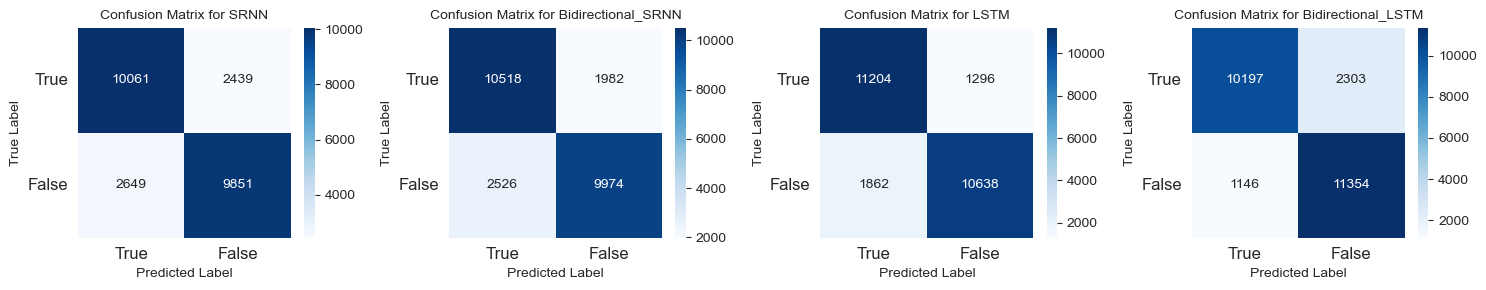

In [18]:
# Создать общую фигуру
fig, axs = plt.subplots(1, len(models), figsize=(15, 3), squeeze=False)

# Вычислить и отобразить матрицы ошибок для каждой модели
for i, model in enumerate(models):
    cm = confusion_matrix(y_test, all_predictions[i])

    df1 = pd.DataFrame(columns=["True", "False"], index=["True", "False"], data=cm)

    sns.heatmap(df1, annot=True, cmap="Blues", fmt=".0f", ax=axs[0, i])
    axs[0, i].set_xlabel("Predicted Label")
    axs[0, i].tick_params(axis="x", labelsize=12)
    axs[0, i].tick_params(axis="y", labelsize=12, rotation=0)
    axs[0, i].set_ylabel("True Label")
    axs[0, i].set_title(f"Confusion Matrix for {model.name}", size=10)

plt.tight_layout()
plt.savefig(f"convolution_matrix_epochs_{epochs}_batch_{batch_size}.pdf")
plt.show()

# Висновки

Експерименти проводились для кількості епох: 5, 10 та 15.

Для процесу навчання на 15-ти епохах можна подивитись результати експериментів на графіках: 
- [криві навчання](./training_curves_epoch_15_batch_128.pdf);
- [результати навчання](./data_epochs_15_batch_128.csv).


Витративши багато часу на навчання на 15-ти епохах, результат мене прикро вразив. Вже починаючи з 5-ї епохи відбувалось суттєве перенавчання. Ускладнювати архітектуру мережі я не став, оскільки це витратись ще більше машинного часу, хоча в коді класу моделі я таку можливість передбачив:
```python
def __init__(self, name="SRNN", max_features=max_features):
        super().__init__(name, max_features, [
         SimpleRNN(units=64),
         # сюди можна додавати шари
         ])
```
Тому я вирішив зупинитись на 5-ти епохах, що тя і залишив у цьому ноутбуці вище. 


| Model              | edu_time | test_loss | test_acc |
|--------------------|----------|-----------|----------|
| SRNN               | 182.65   | 0.49      | 0.81     |
| Bidirectional_SRNN | 304.76   | 0.47      | 0.79     |
| LSTM               | 544.57   | 0.32      | 0.87     |
| Bidirectional_LSTM | 1129.91  | 0.32      | 0.87     |


На такому числі епох для простих архітектур RNN тенденція приблизно видна, і вже можна зробити певні висновки:

1. Моделі LSTM показують крашу точність ніж прості рекурентні мережі SimpleRNN, однак вимагають більшого часу навчання. 

   Можливі причини:
   
   Проблема простих рекурентних нейронних мереж, таких як SimpleRNN, полягає в тому, що вони стикаються з проблемою затухаючого градієнта під час навчання на довгих послідовностях даних. Це може призвести до труднощів у вловлюванні довгострокових залежностей, що особливо важливо для задач аналізу сентименту, де важливим є контекст усього речення або навіть абзацу.

   LSTM має механізм управління пам'яттю, який дозволяє їй зберігати інформацію на тривалих часових інтервалах. Це робить її більш здатною до обробки текстових даних, де важливі залежності на різних рівнях контексту.

2. Двонапрямлені мережі показують дещо гірші результати ніж однонапрямлені. Крім того, вони вимагають більшого часу навчання.

В сентиментальному аналізі двонаправленість не відіграє такої ролі, як в задачах машинного перекладу, а отримані результати можна вважати однаковими в межах похибки для точності $\pm 0.05$. Таку точність можна оцінити з результатів проведених мною експериментів.
